# Nash Q-Learning
This tutorial  demonstrates Nash Q-Learning on a zero-sum strategic (non-extensive) game. 

For the payoff matrix, row player is maximizer, coloumn player is minimizer.

Reference: 

Status: TODO

In [3]:
import numpy as np
! pip install pandas
import pandas as pd
# GameMatrix = np.array([[-2,3], [3,-4]])
GameMatrix = np.array([[0,2,-1], [-1,0,1], [1,-1,0]])

Itr = 10000
print('Game matrix: ')
pd.DataFrame(GameMatrix)


Game matrix: 


,0,1,2
0,0,2,-1
1,-1,0,1
2,1,-1,0


## Get Arbitrary MDP Environment

Reward matrices: $[t, s, (a_1, a_2), s'] -> r$

Transition probability matrices: $[t, s, (a_1, a_2), s'] -> p$

In [70]:
import sys
sys.path.append("../..")
from mars.env.mdp import ArbitraryMDP, MDPWrapper
import numpy as np

num_states = 3
num_actions_per_player = 3
num_trans = 3

env = MDPWrapper(ArbitraryMDP(num_states=num_states, num_actions_per_player=num_actions_per_player, num_trans=num_trans))
trans_matrices = env.env.trans_prob_matrices # shape: [dim_transition, dim_state, dim_action (p1*p2), dim_state]
reward_matrices = env.env.trans_prob_matrices # shape: [dim_transition, dim_state, dim_action (p1*p2), dim_state]

oracle_nash_v, oracle_nash_q, _ = env.NEsolver(verbose=False)
oracle_v_star = oracle_nash_v[0]

oracle_v_star = np.mean(oracle_v_star, axis=0)
print(env.observation_space, env.action_space)
# env.render()
obs = env.reset()
print(obs)
done = False
while not np.any(done):
    obs, r, done, _ = env.step([1,0])
    print(obs, r, done)
print('orcale v star: ', oracle_v_star)


Box(0.0, 12.0, (1,), float32) Discrete(3)
[[0], [0]]
[[5], [5]] [0.5610583525729109, -0.5610583525729109] [False, False]
[[6], [6]] [-0.7261994566288021, 0.7261994566288021] [False, False]
[[9], [9]] [-0.8460871060267345, 0.8460871060267345] [True, True]
orcale v star:  -0.29607107415447115


## Nash Q-Learning

In [30]:
from mars.env.mdp.utils.nash_solver import NashEquilibriumECOSSolver
from mars.equilibrium_solver import NashEquilibriumMWUSolver
import matplotlib.pyplot as plt
np.set_printoptions(threshold=np.inf)

def get_matrix(q_tab, state):
    return q_tab[state]

def get_nash_value(payoff, solver, solver_itr):
    if solver == 'ecos':
        ne = NashEquilibriumECOSSolver(payoff)
        ne_value = ne[0]@payoff@ne[1].T
    elif solver == 'mwu':
        ne, ne_value = NashEquilibriumMWUSolver(payoff, Itr=solver_itr)
    else:
        raise NotImplementedError

    return ne_value

def get_random_action(dim):
    return np.random.randint(0, dim, size=2)

def get_action_from_nash(q_tab, state, solver, solver_itr):
    """ sample action from current 'nash' strategies. """
    payoff = get_matrix(q_tab, state)
    if solver == 'ecos':
        ne = NashEquilibriumECOSSolver(payoff)
    elif solver == 'mwu':
        ne, ne_value = NashEquilibriumMWUSolver(payoff, Itr=solver_itr)
    else:
        raise NotImplementedError
        
    actions = []
    for dist in ne:
        sample_hist = np.random.multinomial(1, dist)
        a = np.where(sample_hist>0)
        actions.append(a)
    return action

def compare_with_oracle(nash_q, oracle_nash_q):
    # nash_q_ = nash_q[:-num_states]  # no nash value for last-step states
    nash_q_ = nash_q
    nash_q_ = nash_q_.reshape(num_trans, num_states, num_actions_per_player, num_actions_per_player)

    mse = np.mean((nash_q_ - np.array(oracle_nash_q))**2)
    return mse

def best_response_value()


(9, 3, 3)
(3, 3, 3, 3)
process: 0.0%, mse:  1.3916078832294372
process: 1.0%, mse:  1.3531908962007748


/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:26: UserWarning: Converting G to a CSC matrix; may take a while.
  warn("Converting G to a CSC matrix; may take a while.")
/home/quantumiracle/anaconda3/envs/x/lib/python3.7/site-packages/ecos/ecos.py:29: UserWarning: Converting A to a CSC matrix; may take a while.
  warn("Converting A to a CSC matrix; may take a while.")


process: 2.0%, mse:  1.3228248058458532
process: 3.0%, mse:  1.2960475080126421
process: 4.0%, mse:  1.2720641135143218
process: 5.0%, mse:  1.2485516123815932
process: 6.0%, mse:  1.2279030883979771
process: 7.000000000000001%, mse:  1.2062060286011007
process: 8.0%, mse:  1.188396989955762
process: 9.0%, mse:  1.1712352248197169
process: 10.0%, mse:  1.1491536267125262
process: 11.0%, mse:  1.132735397966775
process: 12.0%, mse:  1.1142440592502643
process: 13.0%, mse:  1.092122861200256
process: 14.000000000000002%, mse:  1.0740442344197458
process: 15.0%, mse:  1.0563086786767035
process: 16.0%, mse:  1.0411584927792483
process: 17.0%, mse:  1.02182457094058
process: 18.0%, mse:  1.0032380282722337
process: 19.0%, mse:  0.9857136088754881
process: 20.0%, mse:  0.9708423501618048
process: 21.0%, mse:  0.9561309356268973
process: 22.0%, mse:  0.9377307472324912
process: 23.0%, mse:  0.9221543528078674
process: 24.0%, mse:  0.9104564302723807
process: 25.0%, mse:  0.8975270256488278
p

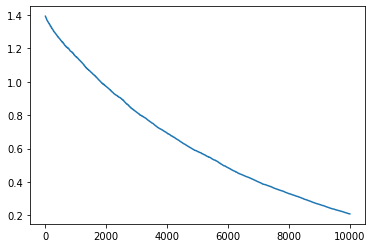

In [34]:
def nash_q_learning(env, gamma = 1, itr = 10000, epsilon = 0.5, solver='ecos', solver_itr=None):
    tau = np.sqrt(np.log(num_actions_per_player)/itr)

    # initialize Nash Q table 
    nash_q_tab = np.ones((num_trans*num_states, num_actions_per_player, num_actions_per_player))  # there is (num_trans+1) state space
    print(nash_q_tab.shape)
    print(np.array(oracle_nash_q).shape)

    mse_list = []
    for i in range(itr):
        mse = compare_with_oracle(nash_q_tab, oracle_nash_q)
        if i % 100 == 0:
            print(f"process: {i/itr*100}%, mse: ", mse)
        mse_list.append(mse)
        obs = env.reset()
        done = False
        while not np.any(done):
            if np.random.random() > epsilon:
                action = get_action_from_nash(nash_q_tab, obs[0][0], solver, solver_itr)
            else:
                action = get_random_action(num_actions_per_player)

            next_obs, r, done, _ = env.step(action)

            if done[0]:  # there is no action and reward for terminal state, so cannot get nash value for its next state
                nash_target = r[0]
            else:
                next_obs_payoff = get_matrix(nash_q_tab, next_obs[0][0])
                next_obs_nash_value = get_nash_value(next_obs_payoff, solver, solver_itr)
                nash_target = r[0]+gamma*next_obs_nash_value*(1-float(done[0]))  # from agent 0's perspective

            nash_q_tab[obs[0][0], action[0], action[1]] = tau*nash_target + (1-tau)*nash_q_tab[obs[0][0], action[0], action[1]]
            obs = next_obs
    print(nash_q_tab)
    return mse_list

mse_list = nash_q_learning(env, epsilon = 0.5)
plt.plot(mse_list)


(9, 3, 3)
(3, 3, 3, 3)
process: 0.0%, mse:  1.3916078832294372
process: 1.0%, mse:  1.3504871167359944
process: 2.0%, mse:  1.3208037260110774
process: 3.0%, mse:  1.2948241104087743
process: 4.0%, mse:  1.2685172153814015
process: 5.0%, mse:  1.2463284014969076
process: 6.0%, mse:  1.2282111131309115
process: 7.000000000000001%, mse:  1.2097115833127825
process: 8.0%, mse:  1.1925617786909763
process: 9.0%, mse:  1.1748627369588411
process: 10.0%, mse:  1.156575537795962
process: 11.0%, mse:  1.1379078526079989
process: 12.0%, mse:  1.1213437348068822
process: 13.0%, mse:  1.1059390275435932
process: 14.000000000000002%, mse:  1.089031932261042
process: 15.0%, mse:  1.0722841814119453
process: 16.0%, mse:  1.0573956086909302
process: 17.0%, mse:  1.03745252295731
process: 18.0%, mse:  1.0213942392254314
process: 19.0%, mse:  1.0047749717216758
process: 20.0%, mse:  0.9901332490885075
process: 21.0%, mse:  0.9773277149176364
process: 22.0%, mse:  0.9601292792374271
process: 23.0%, mse:

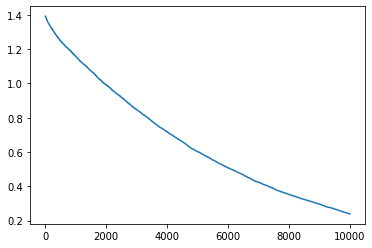

In [35]:
mse_list = nash_q_learning(env, epsilon = 0.5, solver='mwu', solver_itr=100)
plt.plot(mse_list)

Compare Nash Q-learning using different values of $\epsilon$-greedy.

In [51]:
mses = []
Itr = 50000
mses.append(nash_q_learning(env, itr=Itr, epsilon = 0.5))
mses.append(nash_q_learning(env, itr=Itr, epsilon = 1.)) # epsilon=1, purely random action
mses.append(nash_q_learning(env, itr=Itr, epsilon = 0.5, solver='mwu', solver_itr=10))
mses.append(nash_q_learning(env, itr=Itr, epsilon = 1., solver='mwu', solver_itr=10))
mses.append(nash_q_learning(env, itr=Itr, epsilon = 0.5, solver='mwu', solver_itr=100))
mses.append(nash_q_learning(env, itr=Itr, epsilon = 1., solver='mwu', solver_itr=100))

save_path = '../../data/compare_nash_q_learning3.npy'
np.save(save_path, np.array(mses))

(9, 3, 3)
(3, 3, 3, 3)
process: 0.0%, mse:  1.3916078832294372
process: 0.2%, mse:  1.3731837487858127
process: 0.4%, mse:  1.3557621946161185
process: 0.6%, mse:  1.3393350497148822
process: 0.8%, mse:  1.3239818118383482
process: 1.0%, mse:  1.3086835726411281
process: 1.2%, mse:  1.2959108233524577
process: 1.4000000000000001%, mse:  1.2829391662304894
process: 1.6%, mse:  1.272377759530996
process: 1.7999999999999998%, mse:  1.2626267564724953
process: 2.0%, mse:  1.2535660828991846
process: 2.1999999999999997%, mse:  1.2449583784426332
process: 2.4%, mse:  1.2355432861311006
process: 2.6%, mse:  1.225394951216722
process: 2.8000000000000003%, mse:  1.2138223813374678
process: 3.0%, mse:  1.2043374121906856
process: 3.2%, mse:  1.1954768865269463
process: 3.4000000000000004%, mse:  1.1862403550681164
process: 3.5999999999999996%, mse:  1.176938289361293
process: 3.8%, mse:  1.1685128240530516
process: 4.0%, mse:  1.1613636653135015
process: 4.2%, mse:  1.1527399806641359
process: 4

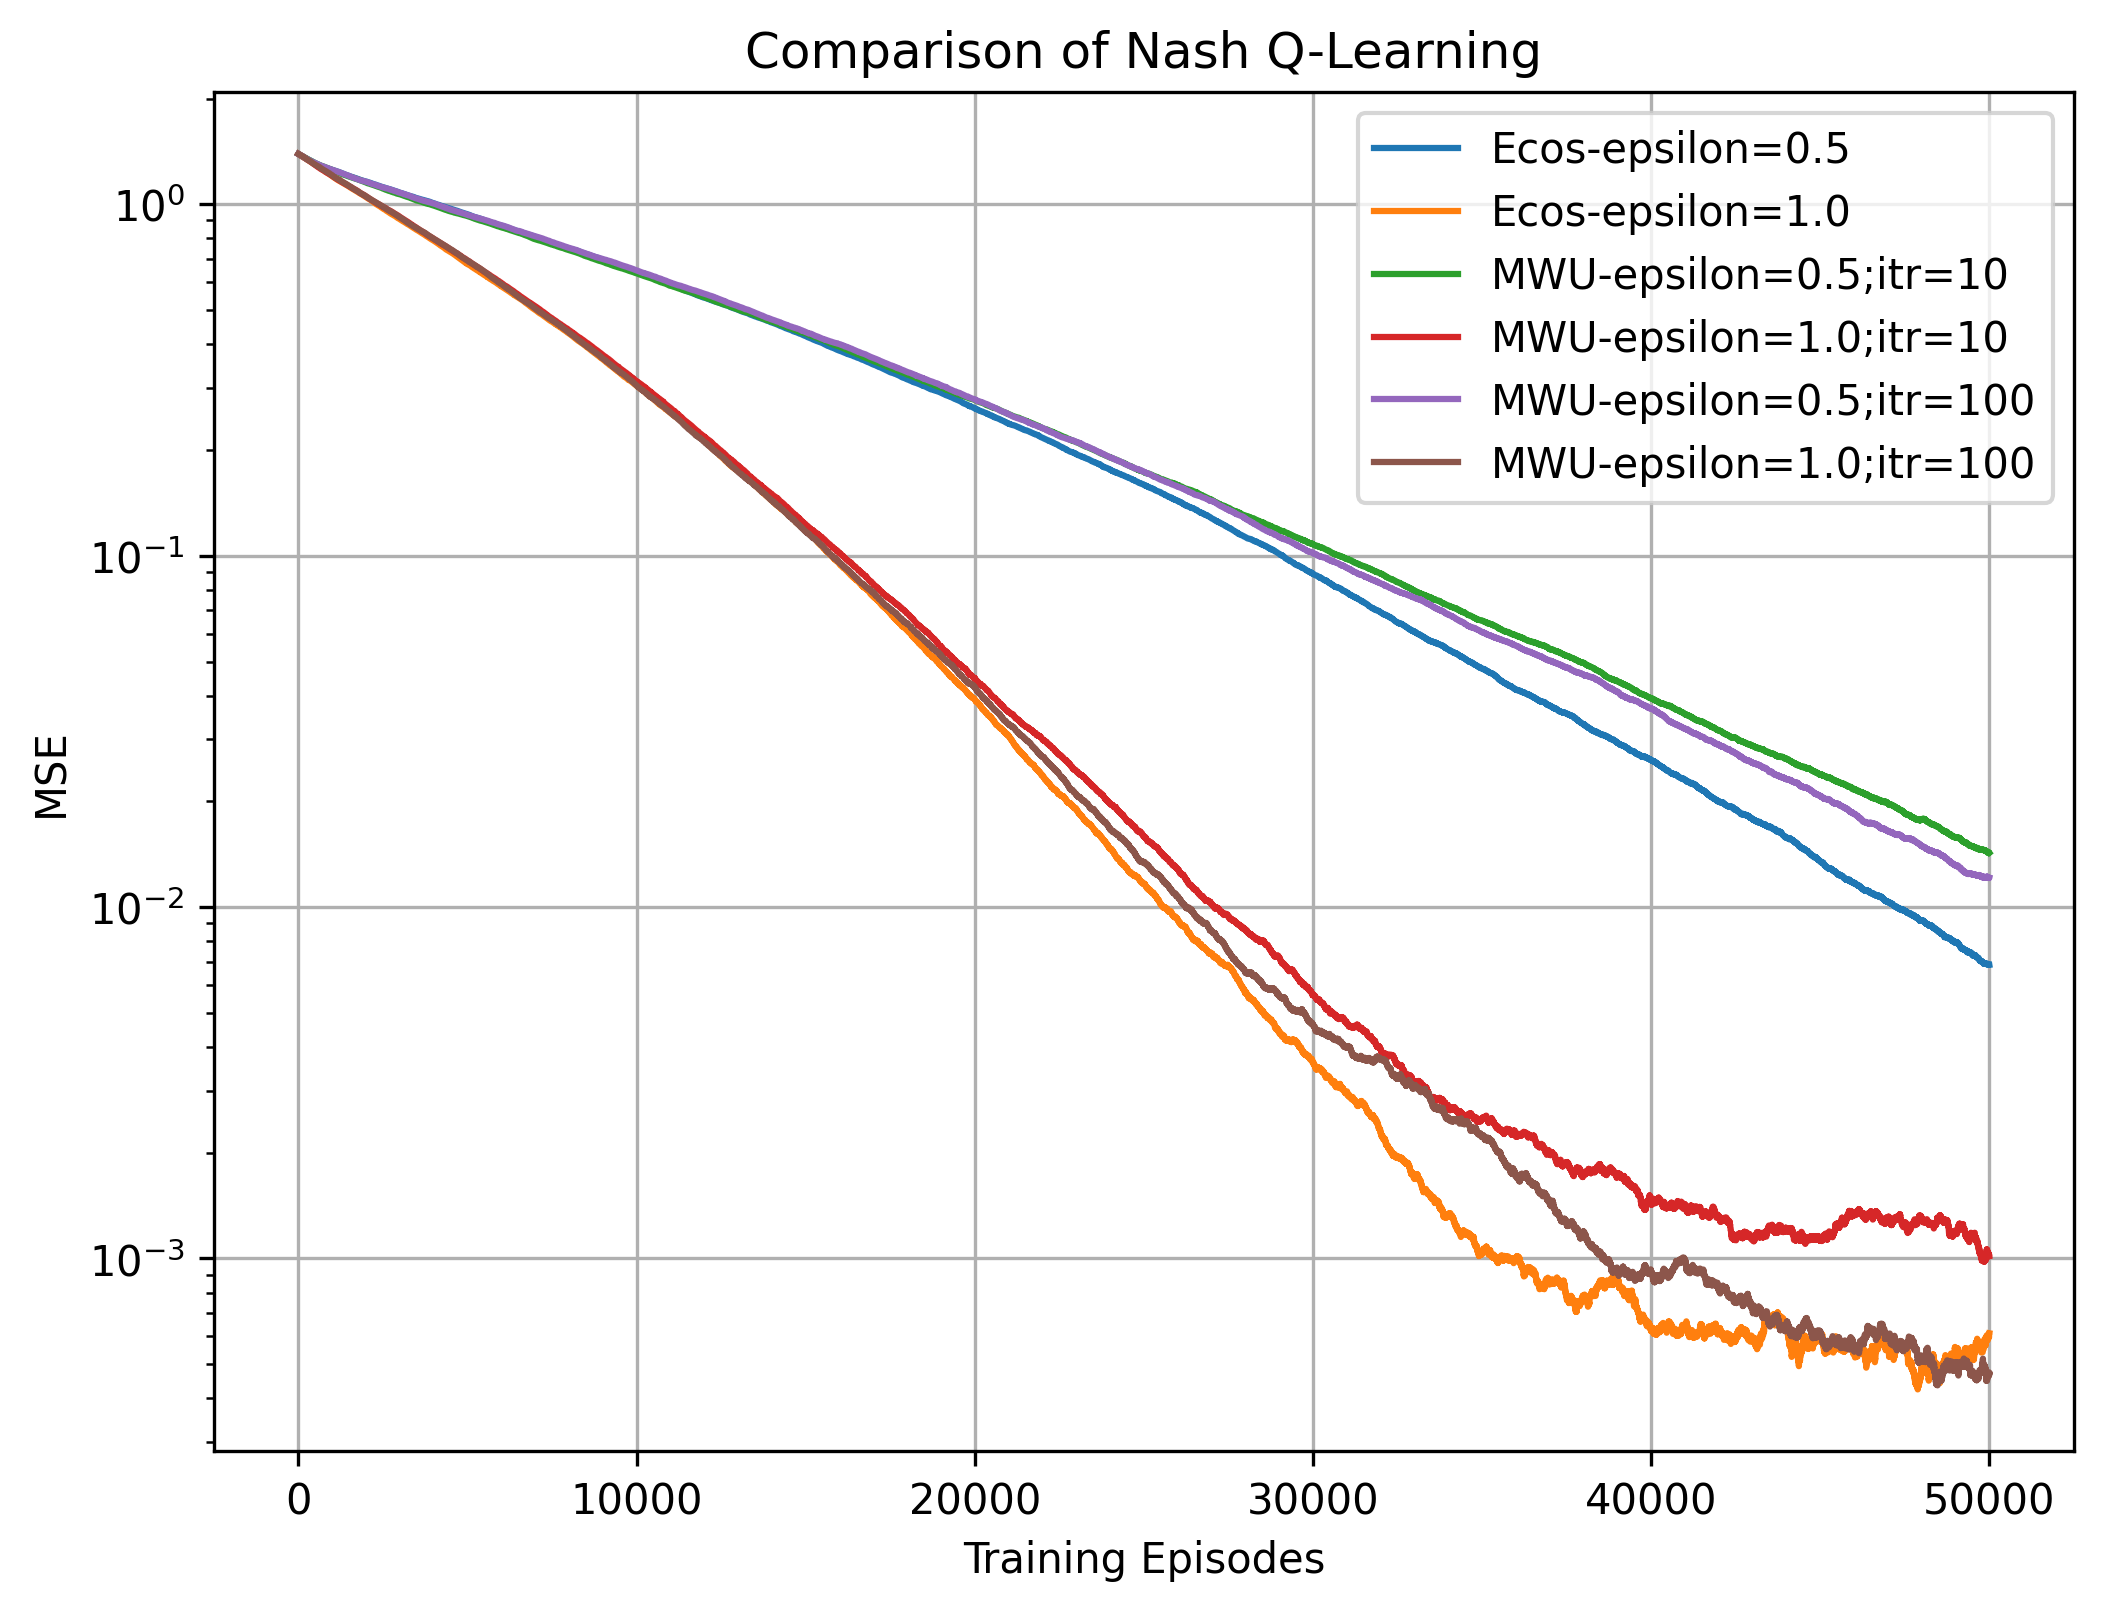

In [53]:
labels = ['Ecos-epsilon=0.5', 'Ecos-epsilon=1.0', 'MWU-epsilon=0.5;itr=10', \
    'MWU-epsilon=1.0;itr=10', 'MWU-epsilon=0.5;itr=100', 'MWU-epsilon=1.0;itr=100' ]

plt.figure(figsize=(8, 6), dpi=300)

save_path = '../../data/compare_nash_q_learning3.npy'
mses = np.load(save_path, allow_pickle=True)

for mse, l in zip(mses, labels):
    plt.plot(mse, label=l)

plt.xlabel('Training Episodes')
plt.ylabel('MSE')
plt.title('Comparison of Nash Q-Learning')
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig('../../data/figs/compare_nash_q_learning.png')
plt.show()

(3, 6, 50000)
(6, 3, 50000)


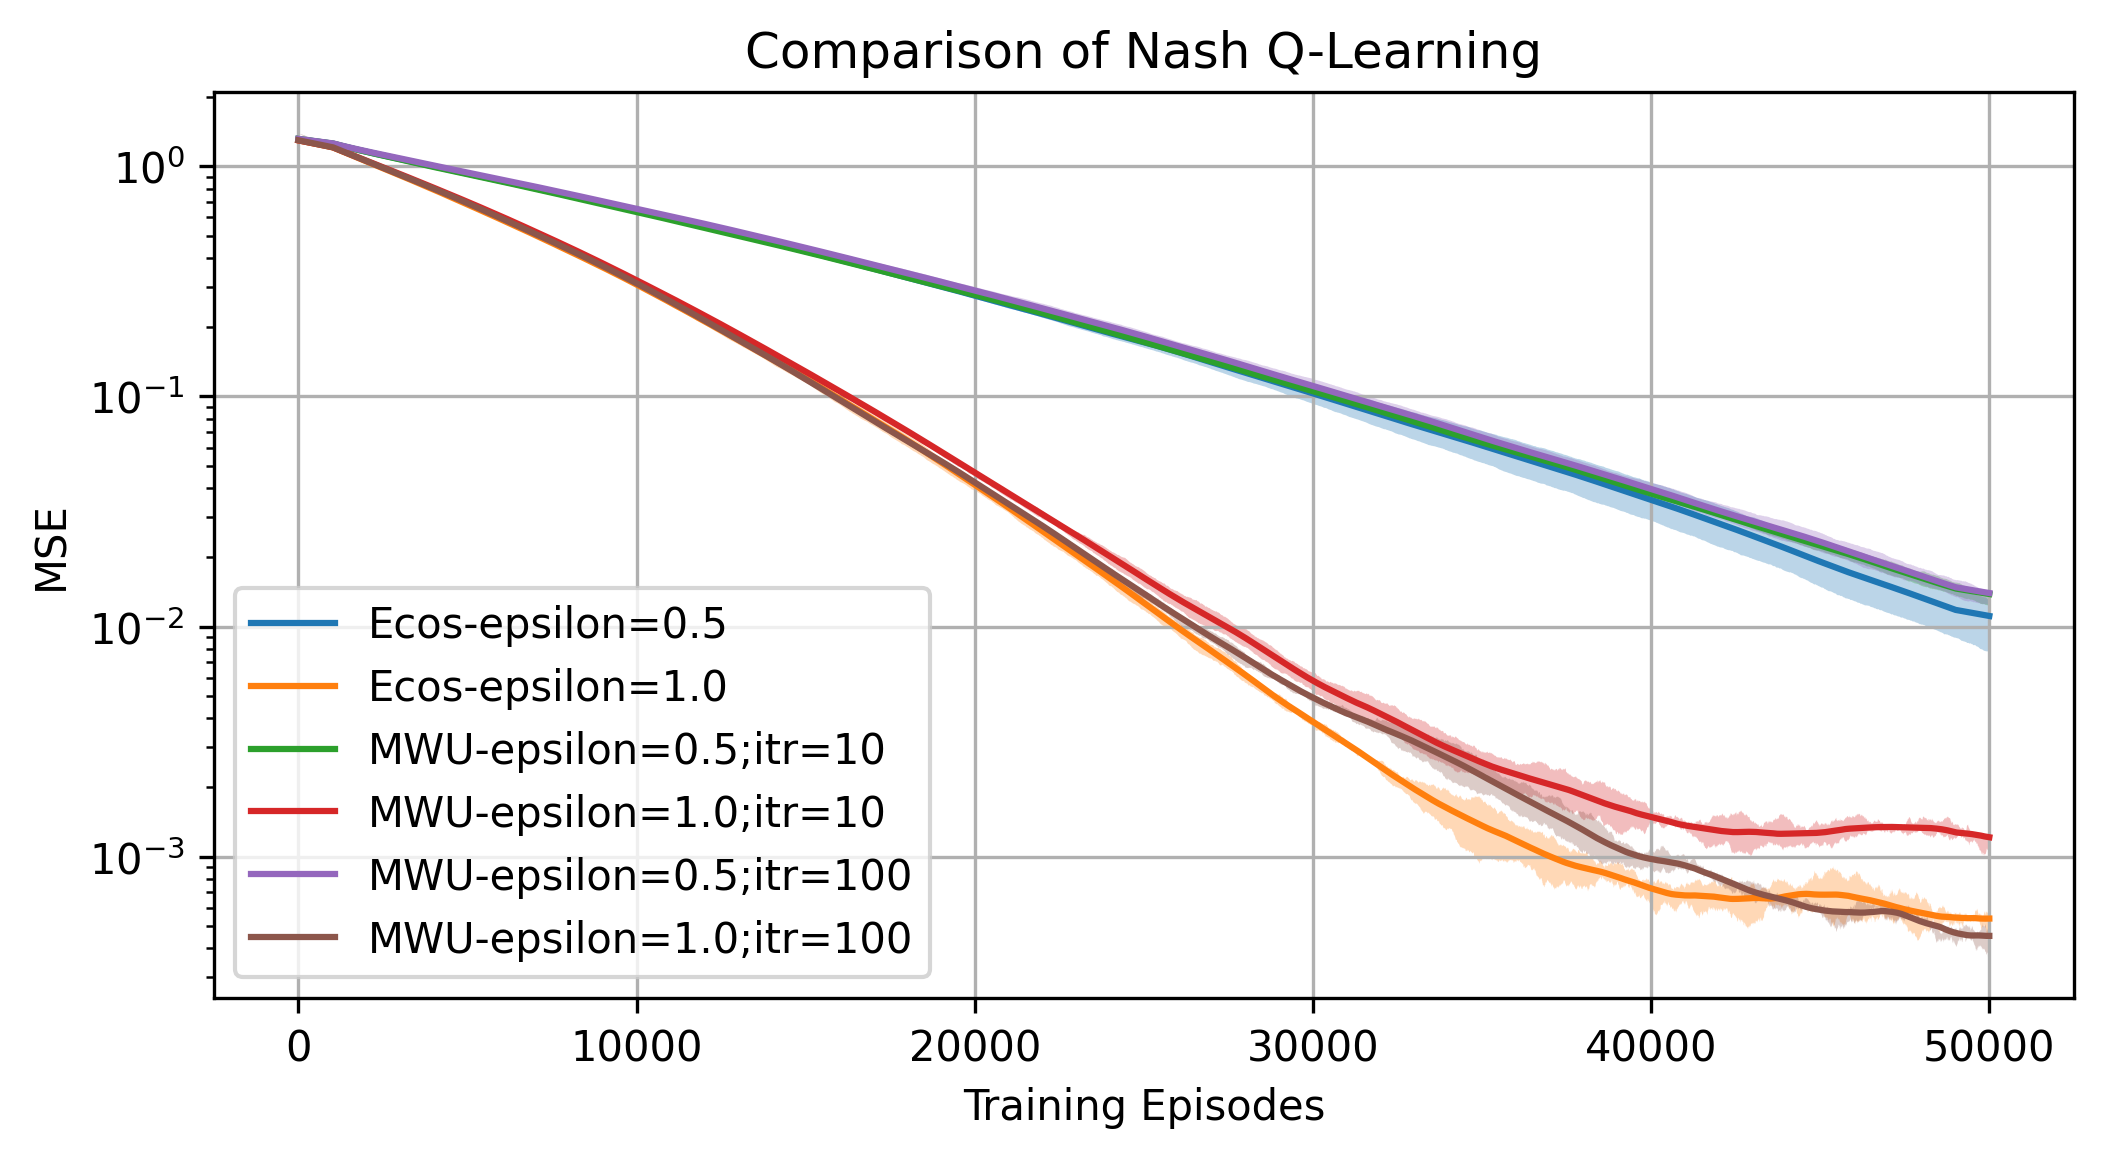

In [63]:
# comparison plot across 3 runs

def smooth(y, radius=1000, mode='two_sided'):
    if len(y) < 2*radius+1:
        return np.ones_like(y) * y.mean()
    elif mode == 'two_sided':
        convkernel = np.ones(2 * radius+1)
        return np.convolve(y, convkernel, mode='same') / \
               np.convolve(np.ones_like(y), convkernel, mode='same')
    elif mode == 'causal':
        convkernel = np.ones(radius)
        out = np.convolve(y, convkernel,mode='full') / \
              np.convolve(np.ones_like(y), convkernel, mode='full')
        return out[:-radius+1]


def plot_with_fill(x, data, label, color=None):
    y_m=np.mean(data, axis=0)
    y_std=np.std(data, axis=0)
    y_upper=y_m+y_std
    y_lower=y_m-y_std
    if color is not None:
        plt.fill_between(
        x, list(y_lower), list(y_upper), interpolate=True, facecolor=color, linewidth=0.0, alpha=0.3
    )   
    else:
        plt.fill_between(
        x, list(y_lower), list(y_upper), interpolate=True, linewidth=0.0, alpha=0.3
    )     
    plt.plot(x, list(smooth(y_m)), color=color, label=label)


labels = ['Ecos-epsilon=0.5', 'Ecos-epsilon=1.0', 'MWU-epsilon=0.5;itr=10', \
    'MWU-epsilon=1.0;itr=10', 'MWU-epsilon=0.5;itr=100', 'MWU-epsilon=1.0;itr=100' ]

plt.figure(figsize=(8, 4), dpi=300)

all_data = []
for i in range(1,4):
    save_path = f'../../data/compare_nash_q_learning{i}.npy'
    mses = np.load(save_path, allow_pickle=True)
    all_data.append(mses)

all_data = np.array(all_data)
print(all_data.shape) 
all_data = np.swapaxes(all_data, 0, 1)
print(all_data.shape) 
x = np.arange(all_data.shape[-1])
for y, l in zip(all_data, labels):
    plot_with_fill(x, y, label=l)

plt.xlabel('Training Episodes')
plt.ylabel('MSE')
plt.title('Comparison of Nash Q-Learning')
plt.yscale('log')
plt.legend()
plt.grid()
plt.savefig('../../data/figs/compare_nash_q_learning_multiple.png')
plt.show()


## Nash Q-Learning with Exploiter